# Title here

Description here

## Table of contents
- [1. Business undestanding](#business)
- [2. Data understanding](#data)
    - [2.1. Gathering data](#gather)
    - [2.2. Assessing data](#assess)
- [3. Prepare data](#prepare)
- [4. Data modeling](#model)
- [5. Evaluate the results](#eval)
- [6. Deploy](#deploy)

<a name="business"></a>
## 1. Business understanding

In this notebook we will try to address the following questions using data from [Stack Overflow Annual Developer Survey](https://insights.stackoverflow.com/survey).

> What are the most popular programming languages over the past five years?\
> What countries have more female respondants?\
> Are male respondants happier than female respondants?\
> What countries have the highest job satisfaction rates?

The following sections serve as a guide in order to understand the data and what needs to be done in order to answer the questions above.

<a name="data"></a>
## 2. Data understanding

We begin our work by downloading the data that we will need in order to address the questions layed out in [Section 1.](#business). We will then proceed to taking a look at our data to get a sense of what needs to be changed later on

<a name="gather"></a>
   

<a name="gather"></a>
### 2.1. Gathering data

First, we need to download all the necessary data. In order to do so, we can run the line below to download all Stack Overflow surveys for all years:

In [ ]:
# Download survey data
%run -i '../download/download.py'

# Download shape files
%run -i '../download/shape.py'

These are all the surveys since 2011. We will only use the ones from the last five years. One of the reasons for doing so is that the structure of the survey changed and similar questions might not be comparable anymore. Next, in preparation for the next sections we can import the relevant libraries.

In [431]:
# Import libraries
import country_converter as coco
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycountry import countries
from tqdm.auto import tqdm
%matplotlib inline

<a name="assess"></a>
### 2.2. Assessing data

Now that we have downloaded all the datasets let's start by reading the csvs from the past five years. In doing so, I am ignoring the first column as it serves as an ordered identifier for the respondants.

In [432]:
# Import survey data and skip first column
import warnings; warnings.simplefilter('ignore')
survey_2016 = pd.read_csv("../data/survey/survey_2016.csv").iloc[:, 1:]
survey_2017 = pd.read_csv("../data/survey/survey_2017.csv").iloc[:, 1:]
survey_2018 = pd.read_csv("../data/survey/survey_2018.csv").iloc[:, 1:]
survey_2019 = pd.read_csv("../data/survey/survey_2019.csv").iloc[:, 1:]
survey_2020 = pd.read_csv("../data/survey/survey_2020.csv").iloc[:, 1:]

# Import shapefile with geopandas
map_df = gpd.read_file("../data/shapefile/world_countries_2017.shp")

Great! Now we can quickly look at what these datasets look like. I will do that by picking two random samples from the survey.

In [433]:
# Show dataframe for two random samples for 2020
pd.options.display.max_columns = None # to show all columns
survey_2020.sample(2)

,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
38694,I am a developer by profession,No,NaN,20,Monthly,24000.0,11748.0,Ukraine,Ukrainian hryvnia,UAH,NaN,NaN,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,"Languages, frameworks, and other technologies ...",Very satisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,Yes,Extremely important,Fairly important,Looking to relocate,"Read company media, such as employee blogs or ...",NaN,Not sure,Onboarding? What onboarding?,No,Often: 1-2 days per week or more,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,NaN,20 to 99 employees,NaN,NaN,NaN,NaN,Yes,"No, not really",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Another engineering discipline (such as civil,...",NaN,NaN,Just as welcome now as I felt last year,40.0,3,Less than 1 year
4172,"I used to be a developer by profession, but no...",Yes,NaN,10,NaN,NaN,NaN,United Kingdom,NaN,NaN,NaN,MySQL,Product manager,"Other doctoral degree (Ph.D., Ed.D., etc.)",Employed full-time,White or of European descent,Man,NaN,NaN,NaN,NaN,Bash/Shell/PowerShell;C;Go;PHP,NaN,NaN,NaN,Jira;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once every few years,No,NaN,No,NaN,Start a free trial,Indifferent,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,Linux;MacOS,NaN,Straight / Heterosexual,Yes,"Yes, somewhat",A few times per month or weekly,A few times per week,Easy,Appropriate in length,No,Mathematics or statistics,NaN,NaN,Somewhat less welcome now than last year,NaN,36,25


And for the remaining years we see:

In [434]:
# Random sample for 2019
survey_2019.sample(2)

,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
78021,I am a developer by profession,Yes,Never,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Japan,"Yes, full-time","Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Received on-the-job training in software devel...,100 to 499 employees,"Developer, front-end;Developer, mobile;Enginee...",11,24,9,Slightly dissatisfied,Slightly dissatisfied,NaN,NaN,NaN,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles;Interview ...,No,Financial performance or funding status of the...,I was preparing for a job search,JPY,Japanese yen,7000000.0,Monthly,767160.0,40.0,There is a schedule and/or spec (made by me or...,Inadequate access to necessary tools;Lack of s...,Less than once per month / Never,Office,A little above average,"Yes, because I see value in code review",6.0,"No, and I'm glad we don't","The CTO, CIO, or other management purchase new...",I have some influence,HTML/CSS;JavaScript,HTML/CSS;Java;JavaScript,MongoDB;PostgreSQL,MongoDB;PostgreSQL,Android;iOS,Android;iOS,Angular/Angular.js;jQuery,Angular/Angular.js;jQuery,Cordova;Node.js,Cordova;Node.js,Android Studio;Atom;Visual Studio Code;Xcode,MacOS,Development;Production,Implementing cryptocurrency-based products,Useful across many domains and could change ma...,Yes,Yes,Yes,YouTube,Online,Username,2011,Multiple times per day,Find answers to specific questions;Learn how t...,More than 10 times per week,Stack Overflow was much faster,60+ minutes,Yes,A few times per month or weekly,Yes,"No, and I don't know what those are","Yes, definitely",A lot more welcome now than last year,Tech articles written by other developers;Indu...,33.0,Man,No,Straight / Heterosexual,South Asian,Yes,Appropriate in length,Easy
836,I am a developer by profession,Yes,Less than once per year,The quality of OSS and closed source software ...,Employed full-time,Israel,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Another engineering discipline (ex. civil, ele...",NaN,2-9 employees,"Developer, back-end;Developer, desktop or ente...",5,14,3,Very satisfied,Slightly dissatisfied,Not at all confident,Yes,Yes,"I’m not actively looking, but I am open to new...",1-2 years ago,Write any code;Solve a brain-teaser style puzz...,No,"Languages, frameworks, and other technologies ...",I heard about a job opportunity (from a recrui...,ILS,Israeli new shekel,23400.0,Monthly,77196.0,28.0,There's no schedule or spec; I work on what se...,Being tasked with non-development work;Inadequ...,"Less than half the time, but at least one day ...",Office,A little above average,No,NaN,"No, but I think we should","The CTO, CIO, or other management purchase new...",I have little or no influence,C,C++;Go;Python,NaN,MongoDB;Redis;SQLite,NaN,AWS;Docker;Google Cloud Platform,NaN,Angular/Angular.js;Django,NaN,.NET;.NET Core;Node.js,Notepad++;Visual Studio Code,MacOS,Development,Implementing cryptocurrency-based products,"Useful for decentralized currency (i.e., Bitcoin)",Y

In [435]:
# Random sample for 2018
survey_2018.sample(2)

,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
70880,Yes,Yes,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","10,000 or more employees",Back-end developer;Front-end developer;Full-st...,9-11 years,6-8 years,Extremely satisfied,Moderately satisfied,Working in a different or more specialized tec...,"I’m not actively looking, but I am open to new...",More than 4 years ago,3.0,9.0,4.0,6.0,1.0,2.0,8.0,5.0,10.0,7.0,1.0,6.0,3.0,9.0,7.0,4.0,10.0,2.0,8.0,11.0,5.0,2.0,1.0,4.0,3.0,5.0,5.0,7.0,1.0,4.0,3.0,6.0,2.0,A recruiter contacted me,U.S. dollars ($),74000,Yearly,74000.0,USD,"Confluence;Other chat system (IRC, proprietary...",Less than a month,Taken a part-time in-person course in programm...,The official documentation and/or standards fo...,NaN,To improve my general technical skills or prog...,Agree,Disagree,Neither Agree nor Disagree,Java;JavaScript;Python;Ruby;Rust;SQL;TypeScrip...,Go;Haskell;JavaScript;Rust;TypeScript;Kotlin,MongoDB;PostgreSQL;Oracle,PostgreSQL;Neo4j;Elasticsearch,AWS,Android;AWS;Azure;Google Home,Angular;Node.js;React,Angular;React,IntelliJ;Sublime Text;Vim;Visual Studio Code,Linux-based,3,Agile;Extreme programming (XP);Formal standard...,Git;Mercurial,Multiple times per day,Yes,Yes,The website I was visiting forced me to disabl...,Somewhat agree,Somewhat agree,Neither agree nor disagree,Saw an online advertisement and then researche...,2.0,5.0,3.0,1.0,6.0,7.0,4.0,"Evolving definitions of ""fairness"" in algorith...",Algorithms making important decisions,Prominent industry leaders,I'm excited about the possibilities more than ...,Depends on what it is,"Yes, but only within the company",NaN,Yes,9,Daily or almost daily,Yes,Less than once per month or monthly,Yes,"No, I know what it is but I don't have one",9,Yes,Very interested,Very interested,Not at all interested,Somewhat interested,Very interested,Between 7:01 - 8:00 AM,9 - 12 hours,1 - 2 hours,1 - 2 times per week,NaN,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor

In [436]:
# Random sample for 2017
survey_2017.sample(2)

,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
31398,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Some college/university study without earning ...,Computer science or software engineering,All or almost all the time (I'm full-time remote),Fewer than 10 employees,"Sole proprietorship or partnership, not in sta...",3 to 4 years,1 to 2 years,NaN,Web developer,Full stack Web developer,NaN,NaN,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a hard ""g,"" like ""gift""",Agree,Agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Agree,Somewhat agree,Somewhat agree,Disagree,Agree,Agree,Agree,Disagree,"I'm not actively looking, but I am open to new...",NaN,Between 2 and 4 years ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not very important,Online course; On-the-job training; Self-taugh...,Official documentation; Trade book; Stack Over...,NaN,Take online courses; Part-time/evening courses...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agile; Scrum,Git,Multiple times a day,NaN,Agree,Disagree,Disagree,Agree,Disagree,Somewhat agree,Hours worked; Customer satisfaction; Benchmark...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [437]:
# Random sample for 206
survey_2016.sample(2)

,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,occupation_group,experience_range,experience_midpoint,salary_range,salary_midpoint,big_mac_index,tech_do,tech_want,aliens,programming_ability,employment_status,industry,company_size_range,team_size_range,women_on_team,remote,job_satisfaction,job_discovery,dev_environment,commit_frequency,hobby,dogs_vs_cats,desktop_os,unit_testing,rep_range,visit_frequency,why_learn_new_tech,education,open_to_new_job,new_job_value,job_search_annoyance,interview_likelihood,how_to_improve_interview_process,star_wars_vs_star_trek,agree_tech,agree_notice,agree_problemsolving,agree_diversity,agree_adblocker,agree_alcohol,agree_loveboss,agree_nightcode,agree_legacy,agree_mars,important_variety,important_control,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
19111,Meta Stack Overflow Post,Australia,Australia and New Zealand,Oceania,30-34,32.0,Male,Developer,Mobile developer,"Mobile Dev (Android, iOS, WP & Multi-Platform)",6 - 10 years,8.0,"$80,000 - $90,000",85000.0,3.74,Android; CoffeeScript; iOS; Java; JavaScript; ...,Android; Arduino / Raspberry Pi; AngularJS; Cl...,Yes,9.0,Employed full-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32403,Meta Stack Overflow Post,Romania,Eastern Europe,Eastern Europe,30-34,32.0,Male,Developer,Front-end web developer,Front-end web developer,2 - 5 years,3.5,"Less than $10,000",5000.0,NaN,JavaScript; PHP; WordPress,JavaScript; PHP; WordPress,No,8.0,Employed full-time,Web Services,100-499 employees,10-14 people,0,Never,I love my job,A friend referred me,Sublime,A few times a month,None,Dogs,Windows 10,I don't know,"1,001 - 5,000",Very rarely,I want to be a better developer,I'm self-taught; On-the-job training,"I'm not actively looking, but I am open to new...",Salary; Office location; Flexible work hours,Writing my CV and keeping it updated,50%,Be more flexible about interview scheduling; S...,Star Wars,Agree completely,Agree somewhat,Agree somewhat,Agree somewhat,Agree completely,Disagree completely,Agree completely,Disagree completely,Disagree completely,Disagree completely,This is very important,I don't care about this,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,I don't care about this,This is somewhat important,Poor scheduling; Poor documentation; Outdated ...,To get help for my job; To give help to others


Now we have a better sense of what the data looks like, so we can proceed to picking the columns that we will need for the analysis, given the questions we outlines in [Section 1.](#business). These are the following:

The columns that indicate what language respondants want to learn are the following:
> Survey 2020: LanguageWorkedWith \
> Survey 2019: LanguageWorkedWith \
> Survey 2018: LanguageWorkedWith \
> Survey 2017: HaveWorkedLanguage \
> Survey 2016: tech_do

The columns that indicate how satisfied a respondant is with their job are:
> Survey 2020: JobSat \
> Survey 2019: JobSat \
> Survey 2018: JobSatisfaction \
> Survey 2017: JobSatisfaction \
> Survey 2016: job_satisfaction

The columns that indicate education status are the following:
> Survey 2020: EdLevel \
> Survey 2019: EdLevel \
> Survey 2018: FormalEducation \
> Survey 2017: FormalEducation \
> Survey 2016: education

The columns that indicate where the respondant lives are:
> Survey 2020: Country \
> Survey 2019: Country \
> Survey 2018: Country \
> Survey 2017: Country \
> Survey 2016: country

The columns that indicate what is the respondant's developer status are:
> Survey 2020: Gender \
> Survey 2019: Gender \
> Survey 2018: Gender \
> Survey 2017: Gender \
> Survey 2016: gender

The columns that indicate what is the respondant's employment status are:
> Survey 2020: Employment \
> Survey 2019: Employment \
> Survey 2018: Employment \
> Survey 2017: EmploymentStatus \
> Survey 2016: employment_status


Lastly, we can take a loop at the shapefiles we imported:

In [438]:
# Head of shapefiles
map_df.head()

,OBJECTID,CNTRY_NAME,CNTRY_CODE,BPL_CODE,geometry
0,1,Algeria,012,13010.0,"MULTIPOLYGON (((-2.05592 35.07370, -2.05675 35..."
1,2,Angola,024,12010.0,"MULTIPOLYGON (((12.79760 -4.41685, 12.79875 -4..."
2,3,In dispute South Sudan/Sudan,9999,99999.0,"POLYGON ((28.08408 9.34722, 28.03889 9.34722, ..."
3,4,Benin,204,15010.0,"MULTIPOLYGON (((1.93753 6.30122, 1.93422 6.299..."
4,5,Botswana,072,14010.0,"POLYGON ((25.16312 -17.77816, 25.16383 -17.778..."


So the countries are in the variable CNTRY_NAME. We will need to match these with our data and for that we will have to harmonize all the country names in [Section 3.](#prepare)

Given all of the above we can proceed to prepare our data!

<a name="prepare"></a>
## 3. Prepare data

Since we already know which columns we will need in order to answer our questions we can first start by droping columns that are not relevant to us:

In [439]:
# Put relevant variables in list
keep_2020 = ['LanguageWorkedWith', 'JobSat', 'EdLevel', 'Country', 'Gender', 'Employment']
keep_2019 = ['LanguageWorkedWith', 'JobSat', 'EdLevel', 'Country', 'Gender', 'Employment']
keep_2018 = ['LanguageWorkedWith', 'JobSatisfaction', 'FormalEducation', 'Country', 'Gender', 'Employment']
keep_2017 = ['HaveWorkedLanguage', 'JobSatisfaction', 'FormalEducation', 'Country', 'Gender', 'EmploymentStatus']
keep_2016 = ['tech_do', 'job_satisfaction', 'education', 'country', 'gender', 'employment_status']

# Keep only relevant variables
survey_2020 = survey_2020[keep_2020]
survey_2019 = survey_2019[keep_2019]
survey_2018 = survey_2018[keep_2018]
survey_2017 = survey_2017[keep_2017]
survey_2016 = survey_2016[keep_2016]

Nice! Now we can rename the columns so that all dataframes have the same names for variables

In [440]:
# Rename columns
survey_2020.rename(columns={'LanguageWorkedWith': 'languages', 'JobSat': 'job_satisfaction', 
                           'EdLevel': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2019.rename(columns={'LanguageWorkedWith': 'languages', 'JobSat': 'job_satisfaction', 
                           'EdLevel': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2018.rename(columns={'LanguageWorkedWith': 'languages', 'JobSatisfaction': 'job_satisfaction', 
                           'FormalEducation': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2017.rename(columns={'LanguageWorkedWith': 'languages', 'JobSatisfaction': 'job_satisfaction', 
                           'FormalEducation': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'EmploymentStatus': 'employment'}, inplace = True)
survey_2016.rename(columns={'tech_do': 'languages', 'job_satisfaction': 'job_satisfaction', 
                           'education': 'education', 'country': 'country', 'gender': 'gender', 
                           'employment_status': 'employment'}, inplace = True);

Now we need to harmonize the answers to different questions for all survey years in order to merge them and have a complete data set. Let's with some an easy one and look at the category for gender in each year.

In [441]:
# Print unique gender categories in 2020
survey_2020['gender'].unique()

array(['Man', nan, 'Woman',
       'Man;Non-binary, genderqueer, or gender non-conforming',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man'], dtype=object)

In [442]:
# Print unique gender categories in 2019
survey_2019['gender'].unique()

array(['Man', nan, 'Woman',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man',
       'Man;Non-binary, genderqueer, or gender non-conforming'],
      dtype=object)

In [443]:
# Print unique gender categories in 2018
survey_2018['gender'].unique()

array(['Male', nan, 'Female',
       'Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Female;Male',
       'Male;Non-binary, genderqueer, or gender non-conforming',
       'Non-binary, genderqueer, or gender non-conforming', 'Transgender',
       'Female;Transgender',
       'Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Female;Non-binary, genderqueer, or gender non-conforming',
       'Female;Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Male;Transgender', 'Female;Male;Transgender',
       'Female;Male;Non-binary, genderqueer, or gender non-conforming',
       'Male;Transgender;Non-binary, genderqueer, or gender non-conforming'],
      dtype=object)

In [444]:
# Print unique gender categories in 2017
survey_2017['gender'].unique()

array(['Male', nan, 'Female', 'Gender non-conforming', 'Other',
       'Male; Gender non-conforming', 'Female; Transgender',
       'Male; Female', 'Male; Other', 'Transgender',
       'Transgender; Gender non-conforming',
       'Female; Gender non-conforming',
       'Male; Female; Transgender; Gender non-conforming; Other',
       'Male; Female; Transgender', 'Male; Female; Other',
       'Male; Female; Transgender; Gender non-conforming',
       'Male; Transgender', 'Female; Transgender; Gender non-conforming',
       'Gender non-conforming; Other',
       'Male; Female; Gender non-conforming', 'Female; Other',
       'Male; Transgender; Gender non-conforming', 'Transgender; Other',
       'Male; Gender non-conforming; Other',
       'Female; Gender non-conforming; Other',
       'Male; Female; Gender non-conforming; Other',
       'Female; Transgender; Other',
       'Female; Transgender; Gender non-conforming; Other',
       'Male; Transgender; Other', 'Male; Female; Transgender;

In [445]:
# Print unique gender categories in 2016
survey_2016['gender'].unique()

array(['Male', nan, 'Female', 'Prefer not to disclose', 'Other'],
      dtype=object)

Given what we see above, let's cluster all in the following four categories: female, male, other, nan. We can define a function to assing the value of Male, Female, Other or nan.

In [446]:
# Define function to harmonize gender
def harmonize_gender(df_raw):
    '''This function unifies all gender categories into 
    four: Male, Female, Other and nan. It also creates 
    binary variables for each of the above categories.
    '''
    # Copy df_raw
    df = df_raw.copy()
    # Binary variable for categories
    df['gender_male'] = 0
    df['gender_female'] = 0
    df['gender_other'] = 0
    df['gender_null'] = 0
    # Loop over rows
    for i in tqdm(df.index):
        # Define gender
        gender = str(df.loc[i, 'gender']).lower()
        # Value if male or man
        if gender == 'male' or gender == 'man':
            df.loc[i, 'gender'] = 'Male'
            df.loc[i, 'gender_male'] = 1
        # Value if female or woman
        elif gender == 'female' or gender == 'woman':
            df.loc[i, 'gender'] = 'Female'
            df.loc[i, 'gender_female'] = 1
        # Assign null values
        elif gender == 'nan':
            df.loc[i, 'gender'] = np.nan
            df.loc[i, 'gender_null'] = 1
        # Other categories lumped into other
        else:
            df.loc[i, 'gender'] = 'Other'
            df.loc[i, 'gender_other'] = 1
    # Return harmonized dataframe
    return(df)

# Apply gender harmonizer
survey_2020 = harmonize_gender(survey_2020)
survey_2019 = harmonize_gender(survey_2019)
survey_2018 = harmonize_gender(survey_2018)
survey_2017 = harmonize_gender(survey_2017)
survey_2016 = harmonize_gender(survey_2016)

We can take a quick look at what the data looks like now:

In [447]:
survey_2020.head()

,languages,job_satisfaction,education,country,gender,employment,gender_male,gender_female,gender_other,gender_null
0,C#;HTML/CSS;JavaScript,Slightly satisfied,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Germany,Male,"Independent contractor, freelancer, or self-em...",1,0,0,0
1,JavaScript;Swift,Very dissatisfied,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",United Kingdom,NaN,Employed full-time,0,0,0,1
2,Objective-C;Python;Swift,NaN,NaN,Russian Federation,NaN,NaN,0,0,0,1
3,NaN,Slightly dissatisfied,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Albania,Male,NaN,1,0,0,0
4,HTML/CSS;Ruby;SQL,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",United States,Male,Employed full-time,1,0,0,0


Similarly, for job satisfaction we can look at the possible values

In [448]:
# Print unique job satisfaction categories in 2020
survey_2020['job_satisfaction'].unique()

array(['Slightly satisfied', 'Very dissatisfied', nan,
       'Slightly dissatisfied', 'Very satisfied',
       'Neither satisfied nor dissatisfied'], dtype=object)

In [449]:
# Print unique job satisfaction categories in 2019
survey_2019['job_satisfaction'].unique()

array([nan, 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very satisfied',
       'Very dissatisfied'], dtype=object)

In [450]:
# Print unique job satisfaction categories in 2018
survey_2018['job_satisfaction'].unique()

array(['Extremely satisfied', 'Moderately dissatisfied',
       'Moderately satisfied', 'Neither satisfied nor dissatisfied',
       'Slightly satisfied', nan, 'Slightly dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [451]:
# Print unique job satisfaction categories in 2017
survey_2017['job_satisfaction'].unique()

array([nan,  9.,  3.,  8.,  6.,  7.,  5.,  4., 10.,  2.,  0.,  1.])

In [452]:
# Print unique job satisfaction categories in 2016
survey_2016['job_satisfaction'].unique()

array([nan, 'I love my job', "I don't have a job",
       "I'm somewhat satisfied with my job",
       "I'm somewhat dissatisfied with my job",
       "I'm neither satisfied nor dissatisfied", 'Other (please specify)',
       'I hate my job'], dtype=object)

We will try to lump all categories into six categories: Very satisfied, satisfied, Neither, Dissatisfied, Very Dissatisfied and nan. We will take a similar approach to gender and define a function to do this.

In [455]:
trial_list = survey_2017['job_satisfaction'].unique().tolist()
for i in trial_list:
    print(str(i) == '9.0')

False
True
False
False
False
False
False
False
False
False
False
False


In [456]:
# Define function to harmonize job satisfaction
def harmonize_jobsatisfaction(df_raw):
    '''This function harmonizes all the job
    satisfaction responses into: Very satisfied,
    Satisfied, Neither, Dissatisfied, Very dissatisfied
    and nan. It also creates binary variables for each
    of the above categories.'''
    # Copy df_raw
    df = df_raw.copy()
    # Values to match
    v_satisfied = ['very satisfied', 'extremely satisfied', 'i love my job', '10.0', '9.0']
    satisfied = ['slightly satisfied', 'moderately satisfied', 'i\'m somewhat satisfied with my job', '8.0', '7.0']
    neither = ['neither satisfied nor dissatisfied', 'i\'m neither satisfied nor dissatisfied', '6.0', '5.0', '4.0']
    dissatisfied = ['slightly dissatisfied', 'moderately dissatisfied', 'i\'m somewhat dissatisfied with my job', '3.0', '2.0']
    v_dissatisfied = ['very dissatisfied', 'extremely dissatisfied', 'i hate my job', '1.0', '0.0']
    # New binary variables
    df['jobsat_v_satisfied'] = 0
    df['jobsat_satisfied'] = 0
    df['jobsat_neither'] = 0
    df['jobsat_disssatisfied'] = 0
    df['jobsat_v_disssatisfied'] = 0
    df['jobsat_null'] = 0
    # Loop over rows
    for i in tqdm(df.index):
        # Define job satisfaction
        job_satisfac = str(df.loc[i, 'job_satisfaction']).lower()
        # Value if very satisfied and assign binary variable
        if job_satisfac in v_satisfied:
            df.loc[i, 'job_satisfaction'] = 'Very satisfied'
            df.loc[i,'jobsat_v_satisfied'] = 1
        # Value if satisfied and assign binary variable
        elif job_satisfac in satisfied:
            df.loc[i, 'job_satisfaction'] = 'Satisfied'
            df.loc[i, 'jobsat_satisfied'] = 1
        # Value if neither and assign binary variable
        elif job_satisfac in neither:
            df.loc[i, 'job_satisfaction'] = 'Neither'
            df.loc[i, 'jobsat_neither'] = 1
        # Value if dissatisfied and assign binary variable
        elif job_satisfac in dissatisfied:
            df.loc[i, 'job_satisfaction'] = 'Dissatisfied'
            df.loc[i, 'jobsat_dissatisfied'] = 1
        # Value if very dissatisfied and assign binary variable
        elif job_satisfac in v_dissatisfied:
            df.loc[i, 'job_satisfaction'] = 'Very Dissatisfied'
            df.loc[i, 'jobsat_v_dissatisfied'] = 1
        # Other categories become np.nan values
        else:
            df.loc[i, 'job_satisfaction'] = np.nan
            df.loc[i, 'jobsat_null'] = 1
    # Return harmonized dataframe
    return(df)
    
    
# Apply job satisfaction harmonizer
survey_2020 = harmonize_jobsatisfaction(survey_2020)
survey_2019 = harmonize_jobsatisfaction(survey_2019)
survey_2018 = harmonize_jobsatisfaction(survey_2018)
survey_2017 = harmonize_jobsatisfaction(survey_2017)
survey_2016 = harmonize_jobsatisfaction(survey_2016)

Again, we can see that this work by looking at a few rows:

In [458]:
survey_2017['job_satisfaction'].head()

0               NaN
1               NaN
2    Very satisfied
3      Dissatisfied
4         Satisfied
Name: job_satisfaction, dtype: object

Next, let's look at the employment variables and how they are layed out

In [459]:
# Print unique employment categories in 2020
survey_2020['employment'].unique()

array(['Independent contractor, freelancer, or self-employed',
       'Employed full-time', nan, 'Student',
       'Not employed, but looking for work', 'Employed part-time',
       'Retired', 'Not employed, and not looking for work'], dtype=object)

In [460]:
# Print unique employment categories in 2019
survey_2019['employment'].unique()

array(['Not employed, and not looking for work',
       'Not employed, but looking for work', 'Employed full-time',
       'Independent contractor, freelancer, or self-employed', nan,
       'Employed part-time', 'Retired'], dtype=object)

In [461]:
# Print unique employment categories in 2018
survey_2018['employment'].unique()

array(['Employed part-time', 'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, and not looking for work',
       'Not employed, but looking for work', nan, 'Retired'], dtype=object)

In [462]:
# Print unique employment categories in 2017
survey_2017['employment'].unique()

array(['Not employed, and not looking for work', 'Employed part-time',
       'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, but looking for work', 'I prefer not to say',
       'Retired'], dtype=object)

In [463]:
# Print unique employment categories in 2016
survey_2016['employment'].unique()

array([nan, 'Employed full-time', 'Freelance / Contractor',
       'Self-employed', "I'm a student", 'Unemployed',
       'Prefer not to disclose', 'Employed part-time',
       'Other (please specify)', 'Retired'], dtype=object)

Now we have to deal with the responses for employment status. This one seems a bit trickier as answer categories have changed over the years. With that in mind, let's create a function to harmonize these categories into the folowing: Full-time, Part-time, Self-employed, Not emplyed, Other and nan.

In [464]:
# Define function to harmonize employment categories
def harmonize_employment(df_raw):
    '''This function harmonizes all employment responses
    into: Full-time, Part-time, Self-employed, Not employed,
    Other and nan. It also creates binary variables for each
    of the above categories.'''
    # Copy df_raw
    df = df_raw.copy()
    # Values to match
    full_time = ['employed full-time']
    part_time = ['employed part-time']
    self_empl = ['independent contractor, freelancer, or self-employed', 'freelance / contractor', 'self-employed']
    not_employed = ['not employed, but looking for work', 'not employed, and not looking for work', 'unemployed']
    other = ['student', 'i\'m a student', 'retired', 'i prefer not to say', 'prefer not to disclose', 'other (please specify)']
    # New binary variables
    df['employment_full_time'] = 0
    df['employment_part_time'] = 0
    df['employment_self_empl'] = 0
    df['employment_not_empl'] = 0
    df['employment_other'] = 0
    df['employment_null'] = 0
    # Loop over rows
    for i in tqdm(df.index):
        # Define employment
        employment = str(df.loc[i, 'employment']).lower()
        # Value if full-time and assign binary variable
        if employment in full_time:
            df.loc[i, 'employment'] = 'Full-time'
            df.loc[i, 'employment_full_time'] = 1
        # Value if part-time and assign binary variable
        elif employment in part_time:
            df.loc[i, 'employment'] = 'Part-time'
            df.loc[i, 'employment_part_time'] = 1
        # Value if self-employed and assign binary variable
        elif employment in self_empl:
            df.loc[i, 'employment'] = 'Self-employed'
            df.loc[i, 'employment_self_empl'] = 1
        # Value if not employed and assign binary variable
        elif employment in not_employed:
            df.loc[i, 'employment'] = 'Not employed'
            df.loc[i, 'employment_not_empl'] = 1
        # Value if other and assign binary variable
        elif employment in other:
            df.loc[i, 'employment'] = 'Other'
            df.loc[i, 'employment_other'] = 1
        # Other categories become np.nan values
        else:
            df.loc[i, 'employment'] = np.nan
            df.loc[i, 'employment_null'] = 1
    # Return harmonized dataframe
    return(df)

# Apply employment harmonizer
survey_2020 = harmonize_employment(survey_2020)
survey_2019 = harmonize_employment(survey_2019)
survey_2018 = harmonize_employment(survey_2018)
survey_2017 = harmonize_employment(survey_2017)
survey_2016 = harmonize_employment(survey_2016)

Now let's look at education variables and their respective values.

In [465]:
# Print unique education categories in 2020
survey_2020['education'].unique()

array(['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)', nan,
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Professional degree (JD, MD, etc.)',
       'Some college/university study without earning a degree',
       'Associate degree (A.A., A.S., etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Primary/elementary school',
       'I never completed any formal education'], dtype=object)

In [466]:
# Print unique education categories in 2019
survey_2019['education'].unique()

array(['Primary/elementary school',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Bachelor’s degree (BA, BS, B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
       'Other doctoral degree (Ph.D, Ed.D., etc.)', nan,
       'Associate degree', 'Professional degree (JD, MD, etc.)',
       'I never completed any formal education'], dtype=object)

In [467]:
# Print unique education categories in 2018
survey_2018['education'].unique()

array(['Bachelor’s degree (BA, BS, B.Eng., etc.)', 'Associate degree',
       'Some college/university study without earning a degree',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       nan, 'Primary/elementary school',
       'Professional degree (JD, MD, etc.)',
       'I never completed any formal education',
       'Other doctoral degree (Ph.D, Ed.D., etc.)'], dtype=object)

In [468]:
# Print unique education categories in 2017
survey_2017['education'].unique()

array(['Secondary school',
       "Some college/university study without earning a bachelor's degree",
       "Bachelor's degree", 'Doctoral degree', "Master's degree",
       'Professional degree', 'Primary/elementary school',
       'I prefer not to answer', 'I never completed any formal education'],
      dtype=object)

In [469]:
# Print unique education categories in 2016
survey_2016['education'].unique().tolist()

[nan,
 "I'm self-taught; On-the-job training; B.S. in Computer Science (or related field)",
 "I'm self-taught; On-the-job training",
 "I'm self-taught",
 'B.S. in Computer Science (or related field)',
 "I'm self-taught; On-the-job training; Online class (e.g. Coursera, Codecademy, Khan Academy, etc.); B.S. in Computer Science (or related field)",
 "I'm self-taught; Online class (e.g. Coursera, Codecademy, Khan Academy, etc.); B.A. in Computer Science (or related field); B.S. in Computer Science (or related field)",
 "I'm self-taught; On-the-job training; Masters Degree in Computer Science (or related field)",
 "I'm self-taught; Online class (e.g. Coursera, Codecademy, Khan Academy, etc.)",
 'Masters Degree in Computer Science (or related field)',
 "I'm self-taught; B.A. in Computer Science (or related field)",
 'B.A. in Computer Science (or related field)',
 "I'm self-taught; On-the-job training; Some college coursework in Computer Science (or related field)",
 'I\'m self-taught; On-th

The answers for 2016 look very different from the previous years. This is probably because respondants were allowed to tick more than one box. We can start to untangle this by putting all possible options in a list called education_options.

In [61]:
# Put education categories into list
education_2016 = survey_2016['education'].unique().tolist()

# Create empty list for possible education options
education_options = []
# Loop over answers and append only unique values
for i in education_2016:
    for opt in str(i).split(';'): # Since options are separated by ;
        # Remove leading white space and append only unique values
        education_options.append(opt.lstrip()) if opt.lstrip() not in education_options else None

This gives us the following available options for respondants

In [62]:
education_options

['nan',
 "I'm self-taught",
 'On-the-job training',
 'B.S. in Computer Science (or related field)',
 'Online class (e.g. Coursera, Codecademy, Khan Academy, etc.)',
 'B.A. in Computer Science (or related field)',
 'Masters Degree in Computer Science (or related field)',
 'Some college coursework in Computer Science (or related field)',
 'Full-time, intensive program (e.g. "boot-camp")',
 'Industry certification program',
 'PhD in Computer Science (or related field)',
 'Part-time program (e.g. night school)',
 'Mentorship program (e.g. Flatiron School, GDI, etc.)']

Now, we want to categorize people into the following categories: Primary education, Secondary education, Some college, Bachelor's , Professional degree, Master's, Doctorates.

Lastly, in order to be able to match the survey data we have with the geodata we imported we need to harminze the name of the countries. In order to do that, we can use the [country_converter library](https://pypi.org/project/country-converter/). We define the following function and apply it to the country values

In [497]:
# Define function to convert country name into ISO3
def country_iso3(df_raw, df_type = 'survey'):
    '''This function createts ISO3 country values 
    column'''
    # Check if df_type valid
    #if df_type != 'survey' or df_survey != 'map':
        ## Exception
    # Copy df_raw
    df = df_raw.copy()
    # If survey is passed
    if df_type == 'survey':
        # Loop over row values
        for i in tqdm(df.index):
            # Define country value
            country = str(df.loc[i, 'country'])
            # Create to ISO3
            df.loc[i, 'iso3'] = coco.convert(names = country, to = 'ISO3')
    # If map is passed
    elif df_type == 'map':
        # Loop over row values
        for i in tqdm(df.index):
            # Define country value
            country = str(df.loc[i, 'CNTRY_NAME'])
            # Convert to ISO3
            df.loc[i, 'iso3'] = coco.convert(names = country, to = 'ISO3')
    # Return dataframe
    return(df)

# Convert surveys into ISO3 
survey_2020 = country_iso3(survey_2020, df_type = 'survey')
survey_2019 = country_iso3(survey_2020, df_type = 'survey')
survey_2018 = country_iso3(survey_2020, df_type = 'survey')
survey_2017 = country_iso3(survey_2020, df_type = 'survey')
survey_2016 = country_iso3(survey_2020, df_type = 'survey')

# Convert map into ISO3
map_df = country_iso3(map_df, df_type = 'map')

KeyboardInterrupt: 

In [502]:
from pycountry import countries

countries.get(name = 'Spain').alpha_3

str

In [544]:
for i in survey_2020['country']:
    if i == i and str(i).lower() != 'nomadic':
        print(i)
        print(countries.search_fuzzy(str(i))[0].alpha_3)

Germany
DEU
United Kingdom
GBR
Russian Federation
RUS
Albania
ALB
United States
USA
Germany
DEU
India
IND
United States
USA
Tunisia
TUN
United Kingdom
GBR
United Kingdom
GBR
Spain
ESP
Netherlands
NLD
United States
USA
France
FRA
United Kingdom
GBR
United States
USA
United States
USA
United States
USA
Spain
ESP
Belgium
BEL
India
IND
Germany
DEU
Germany
DEU
Portugal
PRT
Canada
CAN
United States
USA
China
CHN
Ukraine
UKR
United Kingdom
GBR
Russian Federation
RUS
Canada
CAN
Belgium
BEL
Germany
DEU
United States
USA
United Kingdom
GBR
France
FRA
Italy
ITA
United Kingdom
GBR
United States
USA
United States
USA
United States
USA
United States
USA
Brazil
BRA
France
FRA
France
FRA
United Kingdom
GBR
United States
USA
United States
USA
Austria
AUT
Canada
CAN
United Kingdom
GBR
United States
USA
United States
USA
United States
USA
United States
USA
United States
USA
India
IND
Brazil
BRA
Germany
DEU
Mexico
MEX
United Kingdom
GBR
India
IND
United Kingdom
GBR
United States
USA
Canada
CAN
United Stat

ISR
Brazil
BRA
Latvia
LVA
Canada
CAN
United States
USA
Canada
CAN
United States
USA
United States
USA
United States
USA
Germany
DEU
Albania
ALB
United States
USA
Norway
NOR
Italy
ITA
United States
USA
Pakistan
PAK
United States
USA
United States
USA
United States
USA
Morocco
MAR
United States
USA
Bangladesh
BGD
France
FRA
United States
USA
United States
USA
United States
USA
United Kingdom
GBR
United States
USA
India
IND
United States
USA
United States
USA
United States
USA
United States
USA
United States
USA
United States
USA
United Kingdom
GBR
United States
USA
India
IND
United States
USA
United States
USA
Bulgaria
BGR
United States
USA
United States
USA
India
IND
United States
USA
Italy
ITA
Romania
ROU
Czech Republic
CZE
Canada
CAN
France
FRA
United States
USA
Tunisia
TUN
United States
USA
Germany
DEU
Canada
CAN
United States
USA
Canada
CAN
United States
USA
United States
USA
Canada
CAN
Bangladesh
BGD
Ecuador
ECU
United States
USA
United States
USA
Canada
CAN
United Kingdom
GBR
Unit

LookupError: venezuela, bolivarian republic of...

In [545]:
countries.search_fuzzy('Venezuela')

[Country(alpha_2='VE', alpha_3='VEN', common_name='Venezuela', name='Venezuela, Bolivarian Republic of', numeric='862', official_name='Bolivarian Republic of Venezuela')]

With that in hands we can add a variable at the end of each dataset to mark the year it represents and merge them

In [470]:
# Add year variable to dataframes
survey_2020['year'] = 2020
survey_2019['year'] = 2019
survey_2018['year'] = 2018
survey_2017['year'] = 2017
survey_2016['year'] = 2016

# Merge datasets into one
data = [survey_2020, survey_2019, survey_2018, survey_2017, survey_2016]
survey = pd.concat(data, ignore_index = True)

<a name="model"></a>
## 4. Data modeling

Now that we cleaned and organized our data, we can proceed to answer the questions proposed in [Section 1.](#business).

> What are the most popular programming languages over the past five years?\
> What countries have more female respondants?\
> Are male respondants happier than female respondants?\
> What countries have the higher job satisfaction rates?

### What are the most popular programming languages over the past five years?

Our first question requires us to look at what languages the respondants said they knew how to use and analyze how this has changed over the years.

### What countries have more female respondants?

A big problem in tech (and many other industries) is barrier many women face to get into this industry. We can take a look at how the composition of respondants of the Stack Overflow Annual Developer has changed in order to have an idea if more women are participating in the most important forum for programmers.

In [471]:
# Define survey with average of gender categories
df_gender = survey[['year', 'gender_male', 'gender_female', 'gender_other', 'gender_null']].groupby('year', as_index = False).mean()

# Print head
df_gender.head()

,year,gender_male,gender_female,gender_other,gender_null
0,2016,0.917152,0.057148,0.017776,0.007924
1,2017,0.614668,0.050592,0.016695,0.318046
2,2018,0.601467,0.040716,0.009974,0.347843
3,2019,0.876647,0.071375,0.012860,0.039119
4,2020,0.713811,0.059633,0.010859,0.215696


Above we can see a table with the composition of respondants by gender for the past five years. However, it might be easier to understand what is happening with a graph.

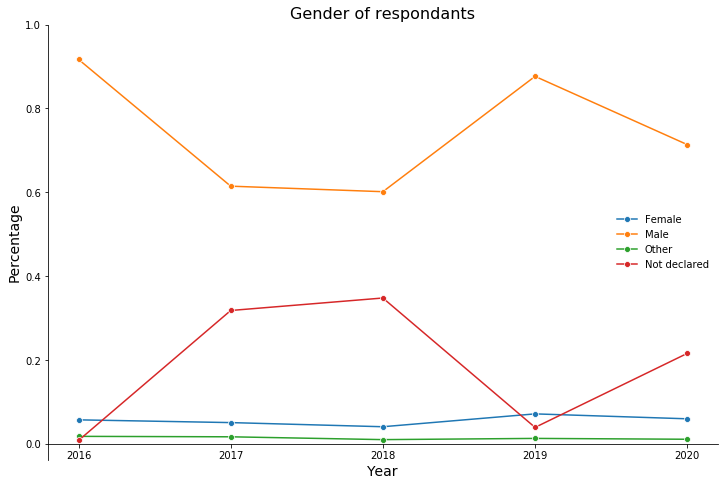

In [472]:
# Set figure size
plt.figure(figsize=(12,8))

# Define graph for each gender category
sns.lineplot(x = 'year', y = 'gender_female', data = df_gender, legend='brief', marker = 'o', label = 'Female')
sns.lineplot(x = 'year', y = 'gender_male', data = df_gender, legend='brief', marker = 'o', label = 'Male')
sns.lineplot(x = 'year', y = 'gender_other', data = df_gender, legend='brief', marker = 'o', label = 'Other')
sns.lineplot(x = 'year', y = 'gender_null', data = df_gender, legend='brief', marker = 'o', label = 'Not declared')

# Set details of plot
plt.title('Gender of respondants', fontsize = 16)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Percentage", fontsize = 14)
plt.xticks(df_gender['year'])
plt.yticks([0,.2,.4, .6, .8, 1])
plt.gca().spines['bottom'].set_position(('data',0))
plt.legend(loc = 'center right', frameon = False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot graph
plt.show();

I looks like women have constantly been under 10% of the respondant pool. It is worth noting, however, that many people choose to not declare their gender. We might want to look at what the composition of male, female and other are only among those people who chose to declare their gender.

In [473]:
# Define gender adjusted dataset
df_gender_adj = df_gender[['year', 'gender_male', 'gender_female', 'gender_other']]

# Set sum of relevat variables
sum_gender = df_gender_adj[['gender_male', 'gender_female', 'gender_other']].sum(axis=1)

# Adjust categories by only those who declared their gender
df_gender_adj['gender_male'] = df_gender_adj['gender_male']/sum_gender
df_gender_adj['gender_female'] = df_gender_adj['gender_female']/sum_gender
df_gender_adj['gender_other'] = df_gender_adj['gender_other']/sum_gender

# Print adjusted gender distributions
df_gender_adj.head()

,year,gender_male,gender_female,gender_other
0,2016,0.924477,0.057604,0.017918
1,2017,0.901332,0.074186,0.024481
2,2018,0.922273,0.062433,0.015294
3,2019,0.912336,0.074280,0.013383
4,2020,0.910121,0.076033,0.013846


With this in hands we can reproduce the graph we did before.

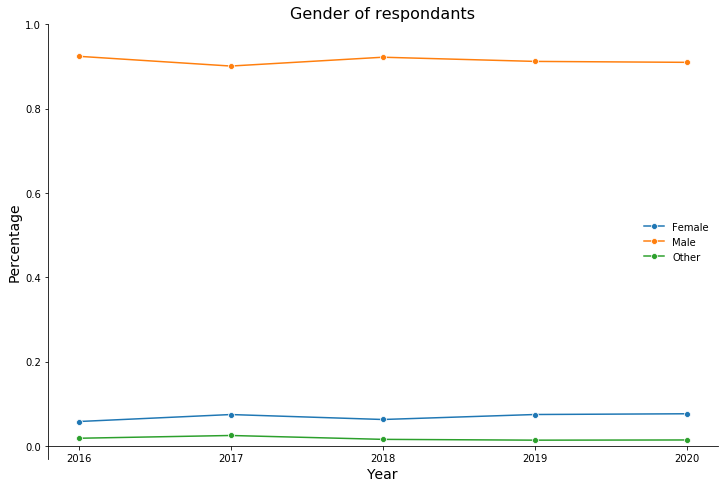

In [474]:
# Set figure size
plt.figure(figsize=(12,8))

# Define graph for each gender category
sns.lineplot(x = 'year', y = 'gender_female', data = df_gender_adj, legend='brief', marker = 'o', label = 'Female')
sns.lineplot(x = 'year', y = 'gender_male', data = df_gender_adj, legend='brief', marker = 'o', label = 'Male')
sns.lineplot(x = 'year', y = 'gender_other', data = df_gender_adj, legend='brief', marker = 'o', label = 'Other')

# Set details of plot
plt.title('Gender of respondants', fontsize = 16)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Percentage", fontsize = 14)
plt.xticks(df_gender['year'])
plt.yticks([0,.2,.4, .6, .8, 1])
plt.gca().spines['bottom'].set_position(('data',0))
plt.legend(loc = 'center right', frameon = False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot graph
plt.show();

This is no surprise as men did constitute the majority of respondants before. This exercise does indicate, however, that there is a lack of participation of women (and other gender identifications) in the Stack Overflow Annual Developer Survey, which could indicate a wider trend in the tech industry that needs to be addressed. Ideally we would want a higher participation of women in the tech industry.

### Are male respondants happier than female respondants?

Seeing that the majority of survey respondants are men, we could check if this translates into men having a higher job satisfaction than women and other gender identities.

In [475]:
score_jobsat = survey[['job_satisfaction', 'gender', 'year']].copy()

In [476]:
score_jobsat['year'].unique()

array([2020, 2019, 2018, 2017, 2016])

In [477]:
# Create new satisfaction score variable
score_jobsat['satisfaction_score'] = np.nan

# Drop rows with null scores
score_jobsat = score_jobsat.dropna(subset = ['job_satisfaction'])

# Loop rows to assign score for score
for i in tqdm(score_jobsat.index):
    if str(score_jobsat.loc[i, 'job_satisfaction']) == 'Very satisfied':
        score_jobsat.loc[i, 'satisfaction_score'] = 5
    elif str(score_jobsat.loc[i, 'job_satisfaction']) == 'Satisfied':
        score_jobsat.loc[i, 'satisfaction_score'] = 4
    elif str(score_jobsat.loc[i, 'job_satisfaction']) == 'Neither':
        score_jobsat.loc[i, 'satisfaction_score'] = 3
    elif str(score_jobsat.loc[i, 'job_satisfaction']) == 'Dissatisfied':
        score_jobsat.loc[i, 'satisfaction_score'] = 2
    elif str(score_jobsat.loc[i, 'job_satisfaction']) == 'Very Dissatisfied':
        score_jobsat.loc[i, 'satisfaction_score'] = 1


In [478]:
#df_jobsat = score_jobsat[['year', 'gender_male', 'gender_female', 'gender_other', 'gender_null']].groupby('year', as_index = False).mean()


<Figure size 864x576 with 0 Axes>

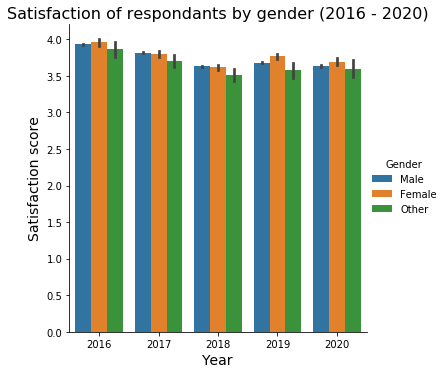

In [492]:
# Set figure size
plt.figure(figsize = (12,8))

# Define graph for satisfaction per gender over years
g = sns.catplot(x = 'year', y = 'satisfaction_score', hue = 'gender', kind= 'bar', data = score_jobsat)
g._legend.set_title("Gender")
# Set details of plot
plt.title('Satisfaction of respondants by gender (2016 - 2020)', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Satisfaction score', fontsize = 14);

It doesn't look like there is a significantly difference in job satisfaction over the years between genders. Note, however, that it does seem that happiness levels were slightly higher in 2016 if compared to the other years.

### What countries have the highest job satisfaction rates?

<a name="eval"></a>
## 5. Evaluate the results

Text text

<a name="deploy"></a>
## 6. Deploy

Text text

In [ ]:
os.getcwd()

In [ ]:
import geopandas as gpd

In [ ]:
map_df = gpd.read_file('IPUMSI_world_release2017/world_countries_2017.shp')

In [ ]:
ax = map_df.plot()
ax.axis('off');

In [ ]:
map_df.head()

In [ ]:
countries = map_df['CNTRY_NAME'].unique().tolist()

In [ ]:
'Bahamas' in countries

In [ ]:
countries2 = survey_2020['Country'].unique().tolist()

In [ ]:
import country_converter as coco

iso_lst1 = []
iso_lst2 = []

for country in countries:
    iso1 = coco.convert(names=country, to='ISO3')
    iso_lst1.append(iso1)

for country2 in countries2:
    iso2 = coco.convert(names=country2, to='ISO3')
    iso_lst2.append(iso2)


In [ ]:
for i in iso_lst2:
    print(i, i in iso_lst1)

In [ ]:
'US' in iso_lst1

In [ ]:
coco.convert(names='United States of America', to='ISO3')

In [ ]:
'USA' in iso_lst2

In [ ]:
for i in survey_2020.index:
    survey_2020.loc[i, 'Country'] = coco.convert(names = str(survey_2020.loc[i, 'Country']), to = 'ISO3')

In [ ]:
survey_2020.head()